### ==============================================================
### Model interpretability and insights
#### Understand *why* the fine-tuned RoBERTa model predicts certain labels, by visualizing word/token importance.
### ==============================================================


In [ ]:
# Libraries
import os
import numpy as np
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from nltk.corpus import stopwords
import nltk

#Stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


torch.manual_seed(42)
np.random.seed(42)

#paths 
path = "C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining"
os.chdir(path)

model_dir = "./models/roberta_finetuned"
results_path = os.path.join(path, "results", "test_predictions_with_confidence.csv")

c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load Model, Tokenizer adn Test Data
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)
df_test = pd.read_csv(results_path)

print(f"Model and tokenizer loaded from: {model_dir}")
print(f"Loaded {len(df_test)} test samples for interpretability analysis.")

Model and tokenizer loaded from: ./models/roberta_finetuned
Loaded 150 test samples for interpretability analysis.


In [3]:
# Initialize Explainer and labels
id2label = {0: "oppose", 1: "support"}
label2id = {"oppose": 0, "support": 1}

#Explainer
cls_explainer = SequenceClassificationExplainer(model, tokenizer)

### Explanation:

SequenceClassificationExplainer uses Integrated Gradients to show how much each token contributes to the final class probability.
Positive (blue/green) values → support that class
Negative (red/orange) → oppose that class

Each visualization will show the input tweet with color highlighting to indicate which words contributed most to the prediction

In [4]:

#Run Explanation on Sample Tweets
examples = [
    df_test.iloc[0]["tweet_text"],
    df_test.iloc[10]["tweet_text"],
    df_test.iloc[50]["tweet_text"]
]

for i, text in enumerate(examples):
    print(f"\nExample {i+1}:\n{text}\n{'-'*60}")
    word_attributions = cls_explainer(text)
    print(f"Predicted label: {cls_explainer.predicted_class_name}")
    cls_explainer.visualize()


Example 1:
Seen on my walk. DTSS gun shop is open for business. Glad I joined colleagues in calling for these shops to close during this crisis. Guns are not essential in this pandemic. (Got some fresh air, now back inside to #StayAtHome) @VAtterbeary @MomsDemand https://t.co/BM256CPRNF https://t.co/xqysAZyNo7
------------------------------------------------------------
Predicted label: LABEL_1



Example 2:
H.R. 5717 and S.3254, the Gun Violence Prevention and Community Safety Act of 2020 aims to deprive gun owners of their right to self-preservation, defense, and flies in the face of the Second Amendment.

Click below to read our open letters.

https://t.co/00bRQJbE4V https://t.co/pOEiH4y9cT
------------------------------------------------------------
Predicted label: LABEL_0



Example 3:
Though measures of self quarantining and sheltering in place might temporarily keep us separated, we can still stand up for what is right. Together we can prevent gun violence.
#endgunviolence https://t.co/NEawn6sBGS
------------------------------------------------------------
Predicted label: LABEL_1


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 100/100 [36:58<00:00, 22.18s/it]
C:\Users\diego\AppData\Local\Temp\ipykernel_2456\2666556927.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="token", data=token_df, palette="Blues_d")


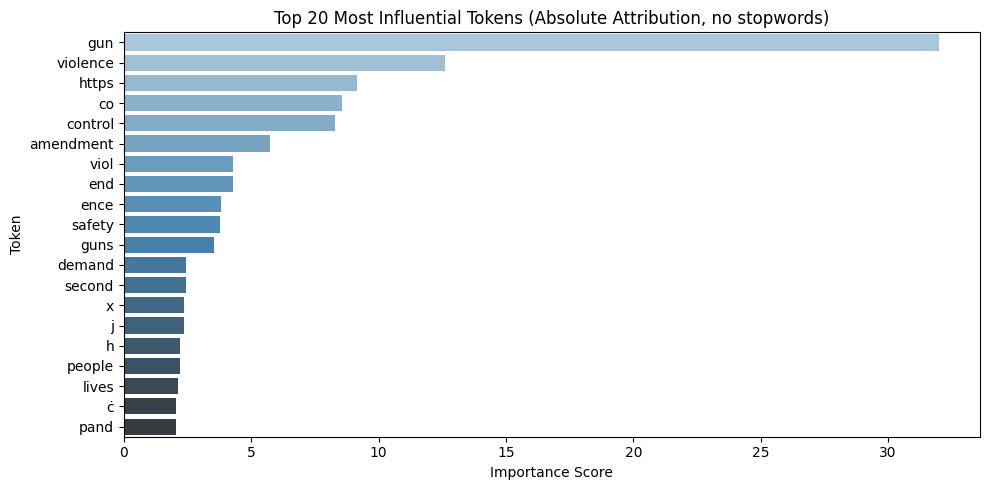

In [7]:
# Aggregate Word Importance 
token_importances = Counter()

sample_texts = df_test.sample(100, random_state=42)["tweet_text"].tolist()

for text in tqdm(sample_texts):
    word_attributions = cls_explainer(text)
    for token, score in word_attributions:
        token_lower = token.lower()
        # Filter out the stopwords
        if token_lower not in stop_words and token_lower.isalpha():
            token_importances[token_lower] += abs(score)


token_df = pd.DataFrame(token_importances.items(), columns=["token", "importance"])
token_df = token_df.sort_values("importance", ascending=False).head(20)

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x="importance", y="token", data=token_df, palette="Blues_d")
plt.title("Top 20 Most Influential Tokens (Absolute Attribution, no stopwords)")
plt.xlabel("Importance Score")
plt.ylabel("Token")
plt.tight_layout()
plt.show()


C:\Users\diego\AppData\Local\Temp\ipykernel_2456\166617122.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], data=df_correct_imp, x="importance", y="token", palette="Greens_d")
C:\Users\diego\AppData\Local\Temp\ipykernel_2456\166617122.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], data=df_wrong_imp, x="importance", y="token", palette="Reds_d")


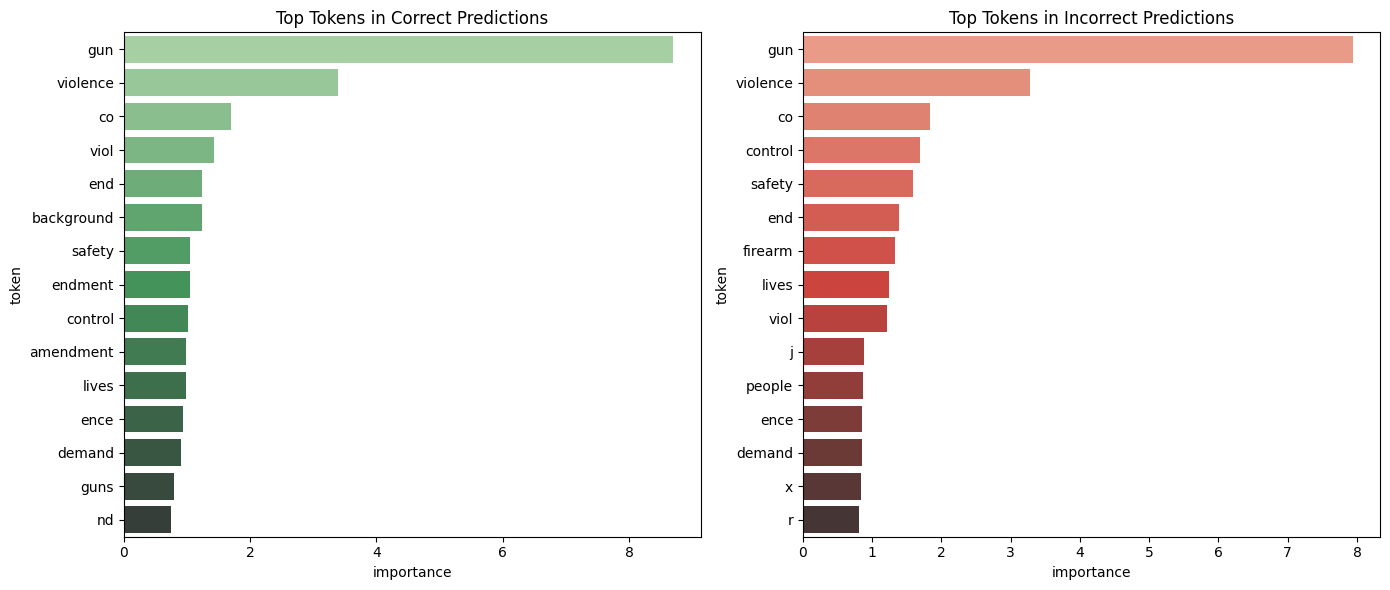

In [8]:
# Compare Correct vs Incorrect Predictions
df_test["correct"] = df_test["label"] == df_test["pred_label"]
correct_texts = df_test[df_test["correct"]].sample(25, random_state=42)["tweet_text"].tolist()
wrong_texts = df_test[~df_test["correct"]].sample(25, random_state=42)["tweet_text"].tolist()

def aggregate_importance(texts):
    agg = Counter()
    for t in texts:
        word_attr = cls_explainer(t)
        for token, score in word_attr:
            token_lower = token.lower()
            # Filter stopwords
            if (token_lower not in stop_words and token_lower.isalpha() and not token_lower.startswith(('@', '#', 'http'))):
                agg[token_lower] += abs(score)
    return pd.DataFrame(agg.items(), columns=["token", "importance"])

#DAtaframe
df_correct_imp = aggregate_importance(correct_texts).sort_values("importance", ascending=False).head(15)
df_wrong_imp = aggregate_importance(wrong_texts).sort_values("importance", ascending=False).head(15)

#Plot
fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.barplot(ax=axes[0], data=df_correct_imp, x="importance", y="token", palette="Greens_d")
axes[0].set_title("Top Tokens in Correct Predictions")

sns.barplot(ax=axes[1], data=df_wrong_imp, x="importance", y="token", palette="Reds_d")
axes[1].set_title("Top Tokens in Incorrect Predictions")

plt.tight_layout()
plt.show()
